In [146]:
import pandas as pd
from pandas_datareader import data as pdr
import yfinance as yf
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

yf.pdr_override()

y_symbols = ['^GSPC', '^MXX', '^FCHI','^NYA','^JKSE', '^RUT','^KS11' ]

start_date = dt.datetime(2000,1,1)
end_date = dt.datetime(2020,1,2)

data = pdr.get_data_yahoo(y_symbols, start=start_date, end=end_date, interval='1mo')['Adj Close']

[*********************100%***********************]  7 of 7 completed


In [147]:
data

,^FCHI,^GSPC,^JKSE,^KS11,^MXX,^NYA,^RUT
Date,,,,,,,
2000-01-01,5659.810059,1394.459961,636.372009,943.880005,6585.669922,6574.009766,496.230011
2000-02-01,6190.959961,1366.420044,576.541992,828.380005,7368.549805,6266.419922,577.710022
2000-03-01,6286.049805,1498.579956,583.276001,860.940002,7473.250000,6848.609863,539.090027
2000-04-01,6419.720215,1452.430054,526.737000,725.390015,6640.680176,6811.169922,506.250000
2000-05-01,6426.259766,1420.599976,454.326996,731.880005,5961.140137,6805.250000,476.179993
...,...,...,...,...,...,...,...
2019-09-01,5677.790039,2976.739990,6169.102051,2063.050049,43011.269531,13004.740234,1523.369995
2019-10-01,5729.859863,3037.560059,6228.316895,2083.479980,43337.281250,13171.809570,1562.449951
2019-11-01,5905.169922,3140.979980,6011.830078,2087.959961,42820.179688,13545.209961,1624.500000


In [148]:
#conversions
# convert in USD, we will use fixed rates
data.iloc[:,0] = data.iloc[:,0]* 1.06      #FCHI
data.iloc[:,4] = data.iloc[:,4]* 0.05      #MXX
data.iloc[:,2] = data.iloc[:,2]* 0.000064  #JKSE
data.iloc[:,3] = data.iloc[:,3]* 0.000773  #KS11

In [149]:
data

,^FCHI,^GSPC,^JKSE,^KS11,^MXX,^NYA,^RUT
Date,,,,,,,
2000-01-01,5999.398662,1394.459961,0.040728,0.729619,329.283496,6574.009766,496.230011
2000-02-01,6562.417559,1366.420044,0.036899,0.640338,368.427490,6266.419922,577.710022
2000-03-01,6663.212793,1498.579956,0.037330,0.665507,373.662500,6848.609863,539.090027
2000-04-01,6804.903428,1452.430054,0.033711,0.560726,332.034009,6811.169922,506.250000
2000-05-01,6811.835352,1420.599976,0.029077,0.565743,298.057007,6805.250000,476.179993
...,...,...,...,...,...,...,...
2019-09-01,6018.457441,2976.739990,0.394823,1.594738,2150.563477,13004.740234,1523.369995
2019-10-01,6073.651455,3037.560059,0.398612,1.610530,2166.864063,13171.809570,1562.449951
2019-11-01,6259.480117,3140.979980,0.384757,1.613993,2141.008984,13545.209961,1624.500000


In [150]:
a = {}

In [239]:
# 10 years sliding window
sliding_windows_data = {}

for j in range(11):
    i=12 *j
    returns = (data / data.shift(1))[1+i:12*10 +i] 
    logReturn = np.log(returns)
    #var(aX) = a^2var(X), cov(aX, aX) = a^2 cov(X,X)
    yearly_mean = 12 * logReturn.mean()
    yearly_var = 12**2 * logReturn.var()
    yearly_std = np.sqrt(yearly_var)
    yearly_cov = 12**2 * logReturn.cov()

    sliding_windows_data[str(j+1) +'_yearly_mean'] = yearly_mean
    sliding_windows_data[str(j+1) +'_yearly_var'] = yearly_var
    sliding_windows_data[str(j+1) +'_yearly_std'] = yearly_std
    sliding_windows_data[str(j+1) +'_yearly_cov'] = yearly_cov

In [240]:
#expected yearly returns:
for j in range(11):
    print("SLIDING WINDOW ", j+1)
    print(sliding_windows_data[str(j+1) +'_yearly_mean'])
    print("____________________________________________________________")

SLIDING WINDOW  1
^FCHI   -0.036619
^GSPC   -0.022544
^JKSE    0.139352
^KS11    0.058306
^MXX     0.159791
^NYA     0.008961
^RUT     0.023328
dtype: float64
____________________________________________________________
SLIDING WINDOW  2
^FCHI   -0.045908
^GSPC   -0.008335
^JKSE    0.218168
^KS11    0.120982
^MXX     0.179562
^NYA     0.012764
^RUT     0.043645
dtype: float64
____________________________________________________________
SLIDING WINDOW  3
^FCHI   -0.034796
^GSPC    0.010771
^JKSE    0.215360
^KS11    0.089974
^MXX     0.169155
^NYA     0.020247
^RUT     0.043126
dtype: float64
____________________________________________________________
SLIDING WINDOW  4
^FCHI    0.021639
^GSPC    0.051513
^JKSE    0.242833
^KS11    0.122638
^MXX     0.201011
^NYA     0.055520
^RUT     0.083205
dtype: float64
____________________________________________________________
SLIDING WINDOW  5
^FCHI    0.016751
^GSPC    0.049521
^JKSE    0.175096
^KS11    0.087034
^MXX     0.152377
^NYA     0.0

In [241]:
#cov_matrices:
for j in range(11):
    print("SLIDING WINDOW ", j+1)
    print(sliding_windows_data[str(j+1) +'_yearly_cov'])
    print("____________________________________________________________")

SLIDING WINDOW  1
          ^FCHI     ^GSPC     ^JKSE     ^KS11      ^MXX      ^NYA      ^RUT
^FCHI  0.459596  0.329017  0.240472  0.383463  0.342218  0.319859  0.402715
^GSPC  0.329017  0.322773  0.265728  0.358319  0.319210  0.312490  0.350575
^JKSE  0.240472  0.265728  0.875803  0.502380  0.440234  0.295676  0.357704
^KS11  0.383463  0.358319  0.502380  0.910074  0.485603  0.348800  0.435574
^MXX   0.342218  0.319210  0.440234  0.485603  0.594206  0.309330  0.453657
^NYA   0.319859  0.312490  0.295676  0.348800  0.309330  0.326133  0.341766
^RUT   0.402715  0.350575  0.357704  0.435574  0.453657  0.341766  0.576767
____________________________________________________________
SLIDING WINDOW  2
          ^FCHI     ^GSPC     ^JKSE     ^KS11      ^MXX      ^NYA      ^RUT
^FCHI  0.476179  0.353584  0.286331  0.424755  0.339411  0.354973  0.414653
^GSPC  0.353584  0.334595  0.281106  0.348661  0.308525  0.333949  0.386399
^JKSE  0.286331  0.281106  0.802027  0.423144  0.391044  0.325093  

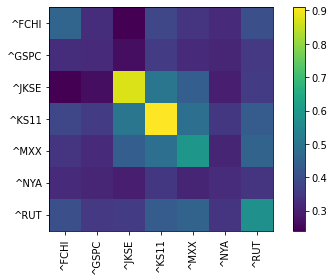

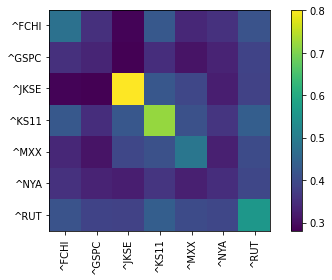

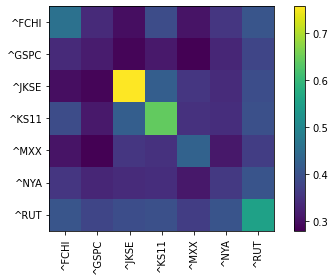

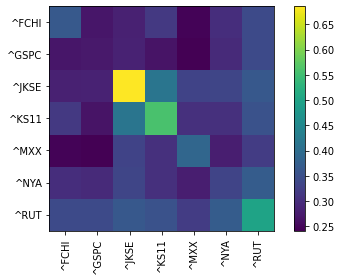

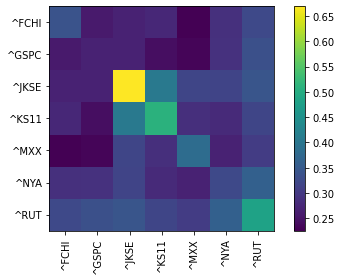

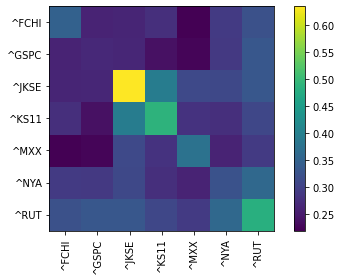

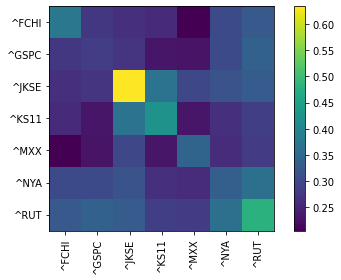

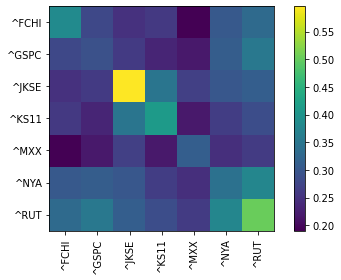

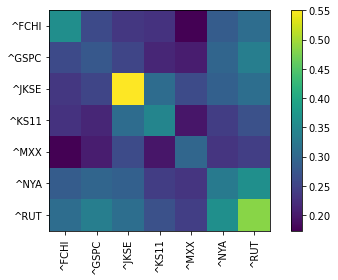

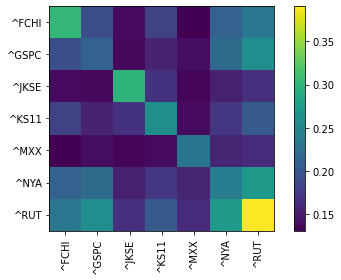

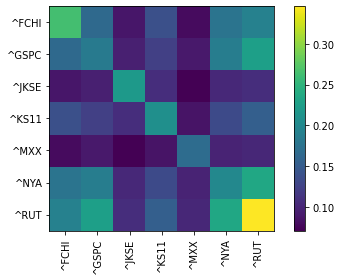

In [242]:
from pypfopt.plotting import plot_covariance
#cov_matrices:
for j in range(11):
    plot_covariance(sliding_windows_data[str(j+1) +'_yearly_cov'])

#### Efficient frontiers

C:\Users\fiori\AppData\Local\Temp\ipykernel_11948\1645145565.py:20: RuntimeWarning: invalid value encountered in divide
  weights /= np.sum(weights)


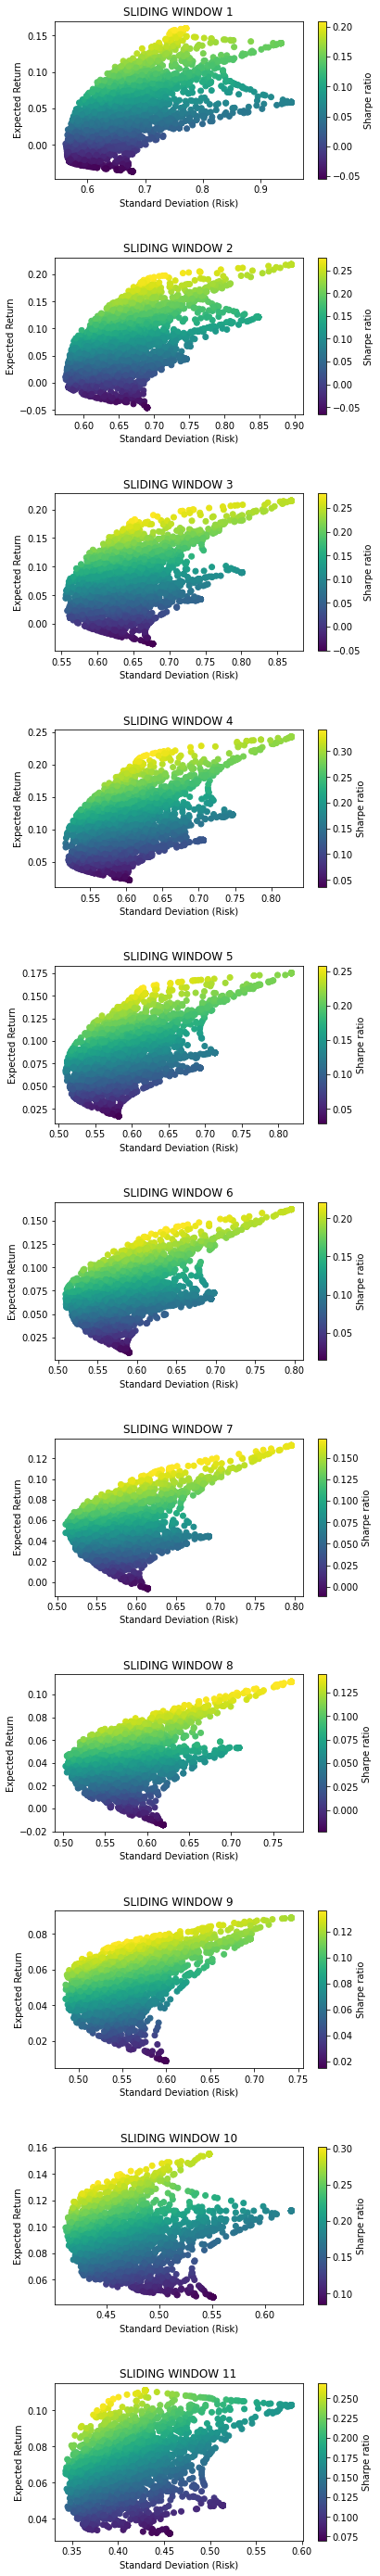

In [243]:
import numpy as np
import matplotlib.pyplot as plt

 #take a list of lists of frontier returns and variances
f_r = []
f_v = []
w = [] #append weights for each portfolio
frontiers_portfolios = []

for j in range(11):
    returns = sliding_windows_data[str(j+1) +'_yearly_mean']
    covariances = sliding_windows_data[str(j+1) +'_yearly_cov']

    frontier_mean_returns = []
    frontier_stds = []

    for i in range(3000):
        weights = np.random.normal(0, 1, size=7) #use normal distribution
        weights = [x if x >= 0 else 0 for x in weights]  
        weights /= np.sum(weights)
        if np.isnan(weights).any():
            continue
        portfolio_return = np.sum(returns * weights)
        portfolio_std = np.sqrt(np.dot(weights.T, np.dot(covariances, weights)))
        frontier_mean_returns.append(portfolio_return)
        frontier_stds.append(portfolio_std)
        w.append(weights)
    frontiers_portfolios.append(w)
    f_r.append(frontier_mean_returns)
    f_v.append(frontier_stds)
    

    
# Create a figure and a 3x3 grid of subplots
fig, axs = plt.subplots(11, figsize=(6, 50))

# Loop through the subplots and plot something on each of them
for i in range(11):
    im = axs[i].scatter(f_v[i], f_r[i], c=(np.array(f_r[i]) / np.array(f_v[i])))
    axs[i].set_xlabel('Standard Deviation (Risk)')
    axs[i].set_ylabel('Expected Return')
    plt.colorbar(im, ax=axs[i], label = 'Sharpe ratio')
    
count = 0
for ax in axs.flat:
    count +=1
    ax.set_title("SLIDING WINDOW " + str(count))

plt.subplots_adjust(wspace=0.5, hspace=0.5)
# Show the plot
plt.show()



In [244]:
#The results might change between runs because the points are computed at random

In [245]:
for i in range(len(f_r)):
    print("Highest return portfolio, Sliding Window ", i +1)
    print(frontiers_portfolios[i][np.argmax(f_r[i])])
    print("__________________________________________")

Highest return portfolio, Sliding Window  1
[0. 0. 0. 0. 1. 0. 0.]
__________________________________________
Highest return portfolio, Sliding Window  2
[0.         0.07505075 0.48931073 0.16408259 0.27155593 0.
 0.        ]
__________________________________________
Highest return portfolio, Sliding Window  3
[0.         0.23933096 0.         0.         0.         0.24481893
 0.51585011]
__________________________________________
Highest return portfolio, Sliding Window  4
[0.         0.47273458 0.         0.32173279 0.         0.20553263
 0.        ]
__________________________________________
Highest return portfolio, Sliding Window  5
[0.         0.         0.12568565 0.         0.27988896 0.1798059
 0.41461949]
__________________________________________
Highest return portfolio, Sliding Window  6
[0.         0.         0.52530649 0.03546333 0.         0.43923019
 0.        ]
__________________________________________
Highest return portfolio, Sliding Window  7
[0.         0.      

In [246]:
# Less risky portfolio
for i in range(len(f_r)):
    print("Lowest risk portfolio, Sliding Window ", i +1)
    print(frontiers_portfolios[i][np.argmin(f_v[i])])
    print("__________________________________________")

Lowest risk portfolio, Sliding Window  1
[0.         0.54081952 0.07185355 0.         0.         0.38732694
 0.        ]
__________________________________________
Lowest risk portfolio, Sliding Window  2
[0.         0.21958276 0.24851411 0.26463485 0.26726828 0.
 0.        ]
__________________________________________
Lowest risk portfolio, Sliding Window  3
[0.         0.17798894 0.0120615  0.22437795 0.         0.16204372
 0.42352789]
__________________________________________
Lowest risk portfolio, Sliding Window  4
[0. 1. 0. 0. 0. 0. 0.]
__________________________________________
Lowest risk portfolio, Sliding Window  5
[0.40551982 0.         0.         0.         0.03057585 0.56390433
 0.        ]
__________________________________________
Lowest risk portfolio, Sliding Window  6
[0.01488639 0.72072259 0.26439102 0.         0.         0.
 0.        ]
__________________________________________
Lowest risk portfolio, Sliding Window  7
[0.00712733 0.1236322  0.652457   0.         0. 

In [247]:
#Highest sharpe ratio

for i in range(11):
    SharpeR = np.array(f_r[i]) / np.array(f_v[i])
    print("Highest Sharpe-ratio portfolio, Sliding Window ", i +1)
    print(frontiers_portfolios[i][np.argmax(SharpeR)])
    print("__________________________________________")

Highest Sharpe-ratio portfolio, Sliding Window  1
[0.         0.         0.14420716 0.         0.85579284 0.
 0.        ]
__________________________________________
Highest Sharpe-ratio portfolio, Sliding Window  2
[0.         0.04846498 0.464418   0.00814478 0.20088277 0.23072445
 0.04736501]
__________________________________________
Highest Sharpe-ratio portfolio, Sliding Window  3
[0. 1. 0. 0. 0. 0. 0.]
__________________________________________
Highest Sharpe-ratio portfolio, Sliding Window  4
[0.21505998 0.         0.21811396 0.56682606 0.         0.
 0.        ]
__________________________________________
Highest Sharpe-ratio portfolio, Sliding Window  5
[0.37950853 0.07798843 0.         0.1006789  0.24709407 0.19473007
 0.        ]
__________________________________________
Highest Sharpe-ratio portfolio, Sliding Window  6
[0.         0.         0.22289859 0.77710141 0.         0.
 0.        ]
__________________________________________
Highest Sharpe-ratio portfolio, Sliding Win

# Let's try to replicate the previous efficient frontiers with a library

In [248]:
!pip install PyPortfolioOpt

Defaulting to user installation because normal site-packages is not writeable


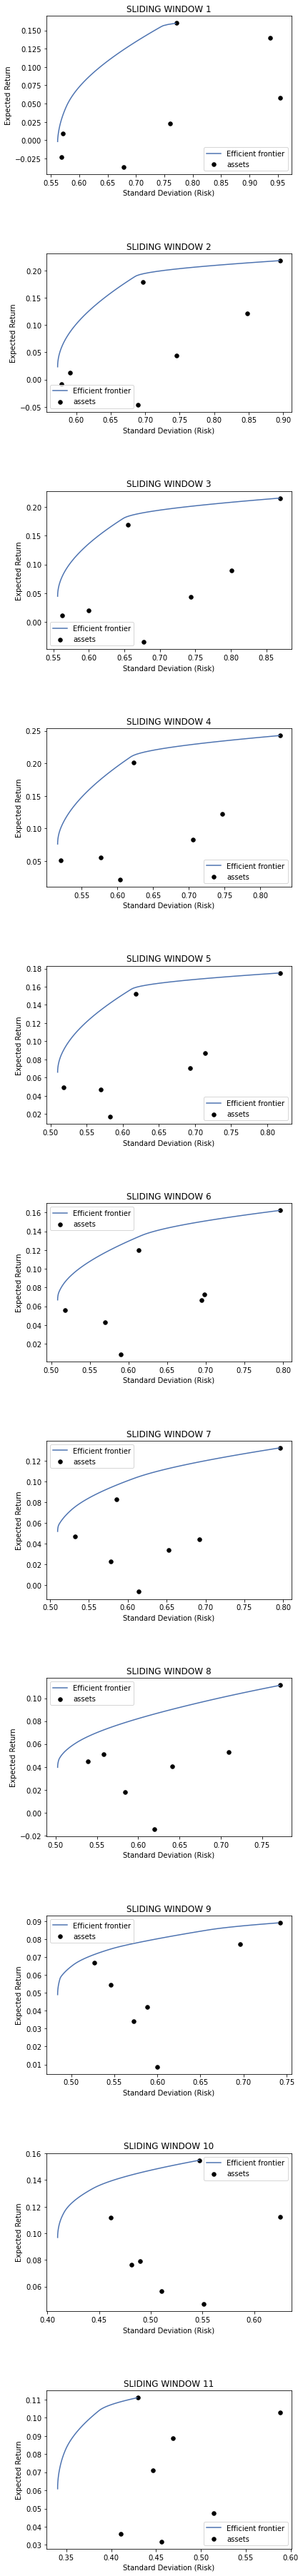

In [249]:
# Create a figure and a 3x3 grid of subplots
fig, axs = plt.subplots(11, figsize=(6, 50))

# Loop through the subplots and plot something on each of them
for i in range(11):
    ef = EfficientFrontier(sliding_windows_data[str(i+1)+'_yearly_mean'], sliding_windows_data[str(i+1)+'_yearly_cov'], weight_bounds=(0, 1))
    plotting.plot_efficient_frontier(ef, ax=axs[i], show_assets=True)
    axs[i].set_xlabel('Standard Deviation (Risk)')
    axs[i].set_ylabel('Expected Return')
    
count = 0
for ax in axs.flat:
    count +=1
    ax.set_title("SLIDING WINDOW " + str(count))

plt.subplots_adjust(wspace=0.5, hspace=0.5)
# Show the plot
plt.show()

### The results are the same, we can use the library to use compute the efficient frontier with risk free rate 1

## Efficient frontier risk free rate

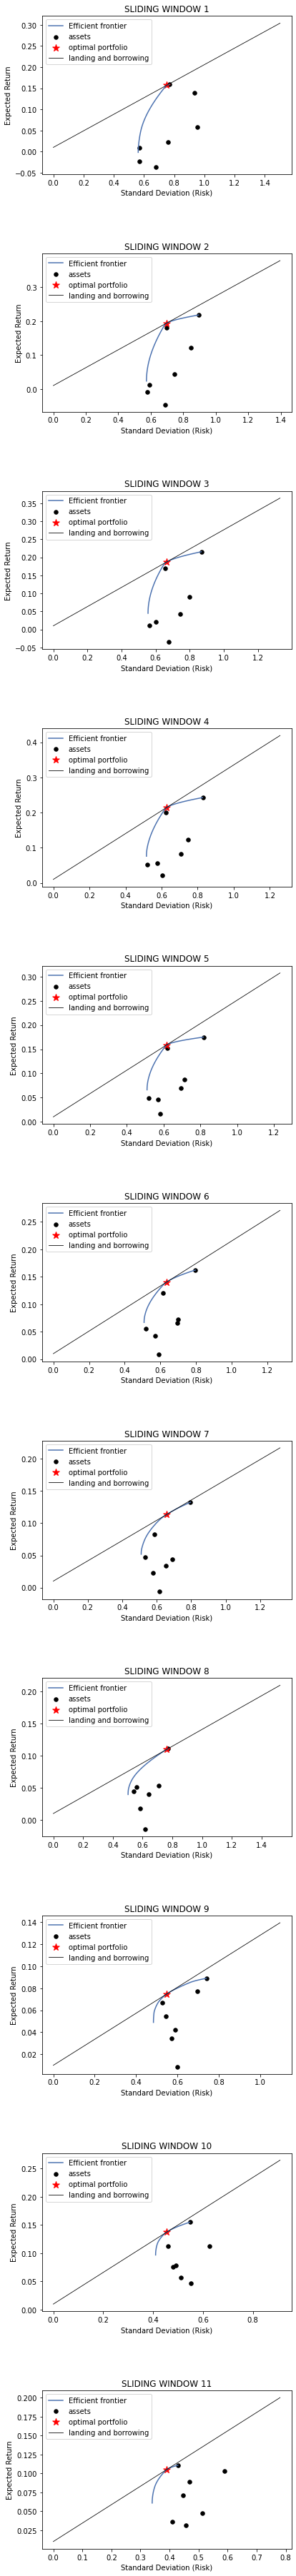

In [267]:
Rf = 0.01


fig, axs = plt.subplots(11, figsize=(6, 50))

# Loop through the subplots and plot something on each of them
for i in range(11):
    ef = EfficientFrontier(sliding_windows_data[str(i+1)+'_yearly_mean'], sliding_windows_data[str(i+1)+'_yearly_cov'], weight_bounds=(0, 1))
    plotting.plot_efficient_frontier(ef, ax=axs[i], show_assets=True)
    #need to create another instance
    ef2 = EfficientFrontier(sliding_windows_data[str(i+1)+'_yearly_mean'], sliding_windows_data[str(i+1)+'_yearly_cov'], weight_bounds=(0, 1))
    Best_portfolio = ef2.max_sharpe(risk_free_rate=0) #best portfolio weights
    stats = ef2.portfolio_performance(verbose=False, risk_free_rate=0)
    Rp = stats[0]
    sigma = stats[1]
    
    xs = np.linspace(0, 2)
    sigma_c = xs * sigma # slide 22 ch05
    Rc = Rf + (Rp - Rf)/sigma * sigma_c
    
    
    opt = axs[i].scatter(sigma, Rp, marker = '*', c = 'red', s=100, label = 'optimal portfolio')#best performance portfolio
    line1, = axs[i].plot(sigma_c, Rc, "-", color="k", linewidth=0.8, label = 'landing and borrowing')
    axs[i].set_xlabel('Standard Deviation (Risk)')
    axs[i].set_ylabel('Expected Return')
    axs[i].legend()
    
count = 0
for ax in axs.flat:
    count +=1
    ax.set_title("SLIDING WINDOW " + str(count))

plt.subplots_adjust(wspace=0.5, hspace=0.5)
# Show the plot
plt.show()
